Mestrado em Modelagem Matematica da Informacao
----------------------------------------------
Disciplina: Modelagem e Mineracao de Dados
------------------------------------------

Master Program - Mathematical Modeling of Information
-----------------------------------------------------
Course: Data Mining and Modeling
--------------------------------

Professor: Renato Rocha Souza
-----------------------------

### Topic: Textual Analysis

Information on the Python Packages used:  
http://docs.python.org/library/re.html  
http://www.pythonware.com/library/pil/handbook/index.htm  
http://nltk.org/  
https://networkx.github.io/  
https://github.com/grangier/python-goose  
https://pypi.python.org/pypi/Topics  
http://radimrehurek.com/gensim/  
http://docs.python-requests.org/en/latest/  

In [119]:
import os
import time
import codecs
import string
import urllib2
import requests
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
import networkx as nx
import re
import re2
import gensim
from collections import OrderedDict, Counter
from bs4 import BeautifulSoup
from goose import Goose
from IPython.core.display import Image
from Topics.onlineldavb import onlineldavb
from Topics.visualization.wordcloud import make_wordcloud
from Topics.visualization.topiccloud import GenCloud
from Topics.visualization.printtopics import list_topics
%matplotlib inline

Specifying the path to the files

In [120]:
datapath = '/home/rsouza/Dropbox/Renato/ModMinDados/Git/datasets/'
outputs = '/home/rsouza/Dropbox/Renato/ModMinDados/outputs/'
oplexicon = 'oplexicon_v3.0/lexico_v3.0.txt'

#### Basic Polarizing Functions for Sentiment Analysis

Loading the polarized lexycom file - OpLexicon (BR)

In [121]:
df_o = pd.read_csv(os.path.join(datapath,oplexicon), header=None, encoding='utf-8', usecols=[0,2], names=[u'palavra',u'polaridade'])
df_o.drop_duplicates(subset=[u'palavra'], take_last=False, inplace=True)
df_o = df_o.set_index(u'palavra')
print(u'Corpus com {} palavras polarizadas'.format(len(df_o)))

Corpus com 32119 palavras polarizadas


In [122]:
def polariza_texto(texto, df1):
    polaridades = []
    ausentes = []
    l_palavras = texto.split()
    for palavra in l_palavras:
        p = palavra.lower().strip()
        if p in df1.index:
            polaridades.append(df1.polaridade[p])
        else:
            ausentes.append(p)
    num_pal = len(l_palavras)
    num_pol = len(polaridades)
    razao_pol = num_pol/float(num_pal) if num_pal else 0.0
    polaridade = sum(polaridades)/float(num_pol) if num_pol else 0.0
    #print('Foram polarizadas {} palavras de um total de {} ({:.2%})'.format(num_pol, num_pal, razao_pol))
    #print('A polaridade mensurada do texto é de {:.3}'.format(polaridade))
    return polaridade, ausentes

In [123]:
def polariza_counter(dicionario, df1):
    polaridades = []
    fator_div = 0
    ausentes = []
    for palavra, frequencia in dicionario.iteritems():
        p = palavra.lower().strip()
        if p in df1.index:
            polaridades.append(df1.polaridade[p] * frequencia)
            fator_div += frequencia
        else:
            ausentes.append((palavra,frequencia))
    num_pal = len(dicionario)
    num_pol = len(polaridades)
    razao_pol = num_pol/float(num_pal) if num_pal else 0.0
    polaridade = sum(polaridades)/float(fator_div)
    print('Foram polarizadas {} palavras de um total de {} ({:.2%})'.format(num_pol, num_pal, razao_pol))
    print('A polaridade mensurada do texto é de {:.3}'.format(polaridade))
    return polaridade, ausentes

#### Capturing some html pages from a newspaper:

In [124]:
url_oglobo = u'http://oglobo.globo.com/busca/?q={}&page={}'
url_uol = u'http://busca.uol.com.br/uol/?ref=homeuol&ad=on&q={}&start={}'
query = u'Corrupcao'
results_pages_to_capture = 2

In [125]:
rawpages = ''
#for i in range(1,results_pages_to_capture + 1): #O Globo
for i in range(0,10*(results_pages_to_capture),10): # UOL
    try:
        print(u'Page {} captured'.format(i)) 
        #request = url_oglobo.format(query,str(i)) #O Globo
        request = url_uol.format(query,str(i)) #UOL
        rawpages = rawpages + urllib2.urlopen(request).read()
    except Exception as inst:
        print type(inst)

Page 0 captured
<class 'urllib2.HTTPError'>
Page 10 captured


In [126]:
links = re.findall(r'(https?://\S+)', rawpages)
links = [l.strip('"') for l in links]
links = [l.split('"')[0] for l in links]
#links = [l for l in links if l.startswith('http://oglobo.globo.com/economia')] #O Globo
#links = [l for l in links if l.startswith('http://economia.uol.com.br/')] #UOL
#links = [l for l in links if not (l.endswith('png') or l.endswith('ico') or l.endswith('css') or l.endswith('jpg'))] #O Globo
links = sorted(list(set(links)))

print('{} extracted links'.format(len(links)))
for link in links:
    print link

21 extracted links
http://barra.uol.com.br/b/scripts/uol.js?refbusca=busca
http://dic.busca.uol.com.br/result.html?q=Corrupcao&amp;group=0&amp;t=10
http://economia.uol.com.br/noticias/infomoney/2015/02/19/justica-quer-saber-se-hsbc-ajudou-a-esconder-dinheiro-de-corrupcao-na-petrobras.htm
http://jsuol.com.br/p/busca/uol/ads.js
http://jsuol.com.br/p/busca/uol/uolbuscad.css
http://mais.b.uol.com.br/sys/search?num=12&amp;start=1&amp;lm=1&amp;order=1&amp;types=V&amp;edFilter=&amp;safeSearch=&amp;viewHotContent=0&amp;q=Corrupcao
http://me.jsuol.com.br/omtr/busca.js
http://noticias.uol.com.br/busca/?q=Corrupcao&amp;id=1&amp;rd=1&amp;ad=on&amp;ref=busca
http://noticias.uol.com.br/opiniao/coluna/2014/12/09/sociedade-precisa-colaborar-no-combate-a-corrupcao.htm
http://noticias.uol.com.br/politica/ultimas-noticias/2014/12/09/a-corrupcao-vai-acabar-no-brasil-sete-fatos-indicam-que-pode-demorar.htm
http://olhardigital.uol.com.br/pro/noticia/tim-e-investigada-por-suspeita-de-corrupcao/47732
http://s

In [127]:
def goose_extract(htmltxt):
    g = Goose({'use_meta_language': False, 'target_language':'pt'})
    article = g.extract(url=htmltxt)
    title = article.title
    meta = article.meta_description
    txt = article.cleaned_text
    fig = article.top_image.src
    return txt, title, meta, fig

In [128]:
deupau = []
for link in links:
    try:
        print(link)
        rawpage = goose_extract(link)[0]
        f = codecs.open(os.path.join(outputs,'html_out','{}'.format(link[24:].replace('/','_'))), mode='w', encoding='utf-8')
        f.write(rawpage)
        f.close()
        print('Sucesso!\n')
        time.sleep(1)
    except Exception as inst:
        print type(inst)
        deupau.append(link)
        print('Insucesso!\n')
        time.sleep(0.5)

http://barra.uol.com.br/b/scripts/uol.js?refbusca=busca
Sucesso!

http://dic.busca.uol.com.br/result.html?q=Corrupcao&amp;group=0&amp;t=10
<type 'exceptions.AttributeError'>
Insucesso!

http://economia.uol.com.br/noticias/infomoney/2015/02/19/justica-quer-saber-se-hsbc-ajudou-a-esconder-dinheiro-de-corrupcao-na-petrobras.htm
Sucesso!

http://jsuol.com.br/p/busca/uol/ads.js
<type 'exceptions.AttributeError'>
Insucesso!

http://jsuol.com.br/p/busca/uol/uolbuscad.css
<type 'exceptions.AttributeError'>
Insucesso!

http://mais.b.uol.com.br/sys/search?num=12&amp;start=1&amp;lm=1&amp;order=1&amp;types=V&amp;edFilter=&amp;safeSearch=&amp;viewHotContent=0&amp;q=Corrupcao
<type 'exceptions.AttributeError'>
Insucesso!

http://me.jsuol.com.br/omtr/busca.js
<type 'exceptions.AttributeError'>
Insucesso!

http://noticias.uol.com.br/busca/?q=Corrupcao&amp;id=1&amp;rd=1&amp;ad=on&amp;ref=busca
<class 'lxml.etree.XMLSyntaxError'>
Insucesso!

http://noticias.uol.com.br/opiniao/coluna/2014/12/09/sociedade

In [129]:
for biziu in deupau:
    print biziu

http://dic.busca.uol.com.br/result.html?q=Corrupcao&amp;group=0&amp;t=10
http://jsuol.com.br/p/busca/uol/ads.js
http://jsuol.com.br/p/busca/uol/uolbuscad.css
http://mais.b.uol.com.br/sys/search?num=12&amp;start=1&amp;lm=1&amp;order=1&amp;types=V&amp;edFilter=&amp;safeSearch=&amp;viewHotContent=0&amp;q=Corrupcao
http://me.jsuol.com.br/omtr/busca.js
http://noticias.uol.com.br/busca/?q=Corrupcao&amp;id=1&amp;rd=1&amp;ad=on&amp;ref=busca
http://shopping.busca.uol.com.br/busca.html?ad=on&amp;ref=busca&amp;q=Corrupcao
http://vestibular.uol.com.br/resumo-das-disciplinas/atualidades/corrupcao-uma-questao-cultural-ou-falta-de-controle.htm
http://www.google.com/adsense/search/ads.js
http://www.omniture.com


Examinando os arquivos e pastas:

In [130]:
corpuspath = os.path.join(outputs,'html_out')
onlydirs = [f for f in os.listdir(corpuspath) if os.path.isdir(os.path.join(corpuspath,f)) and not f.startswith('.')]
onlyfiles = [f for f in os.listdir(corpuspath) if os.path.isfile(os.path.join(corpuspath,f)) and not f.startswith('.')]
onlydirs.sort()

print 'Files in the folder:'
for i, w in enumerate(onlyfiles[0:]):
    print i+1, '--' ,w

Files in the folder:
1 -- br_cotidiano_ultimas-noticias_2013_11_29_stf-nega-pedido-de-suzane-von-richthofen-para-cumprir-pena-em-regime-semiaberto.htm
2 -- m.br_mercado_2015_03_1600560-governo-acredita-que-so-solucao-politica-vai-conter-alta-do-dolar.shtml
3 -- br_politica_ultimas-noticias_2015_03_18_em-meio-a-crise-dilma-anuncia-medidas-de-combate-a-corrupcao.htm
4 -- m.br_cotidiano_2014_10_1539383-suzane-ritchofen-se-casa-com-sequestradora-em-presidio-de-sp.shtml
5 -- br_noticias_manaus-amazonas-amazonia-Suzane-Von-Richthofen-casa-sequestradora-dentro-prisao-ex-Elize-Matsunada-crimes-noticias_0_1238276163.html
6 -- br_cotacoes_noticias_redacao_2014_12_16_dolar-tem-5-alta-seguida-e-passa-de-r-273-pela-1-vez-em-mais-de-9-anos.htm
7 -- _brasil_noticias_1634704-suzane-von-richthofen-se-casou-com-sequestradora-em-presidio
8 -- m.br_poder_2014_10_1532686-acusacoes-de-corrupcao-e-nepotismo-acirram-primeiro-debate-do-2-turno.shtml
9 -- br_opiniao_coluna_2014_12_09_sociedade-precisa-colaborar

Carregando os corpora:

In [131]:
raw_texts = ''
list_raw_texts = []
for filename in onlyfiles:
    page_txt = codecs.open(os.path.join(corpuspath,filename), encoding='utf-8').read()
    raw_texts += u'\n'+ page_txt.lower()
    list_raw_texts.append(page_txt)

Ocorrências de determinada expressão no corpus

In [132]:
#expressao = u'nova_classe_média'.lower()
#expressao = u'Marcelo Néri'.lower()
expressao = u'Brasil'.lower()
#expressao = u'índice'.lower()
#expressao = u'Instituto de Pesquisa'.lower() #muitas grafias diferentes para o Ipea
#expressao = u'Ipea'.lower()
#expressao = u'porta dos fundos'.lower()

In [133]:
pos = 0 
positions = []
while pos != -1:
    position = raw_texts.find(expressao,pos+1)
    pos = position
    positions.append(position)
positions.pop()
print(u'A expressão buscada ocorre {} vezes'.format(len(positions)))

A expressão buscada ocorre 56 vezes


In [134]:
for position in positions: #[0:10]:
    print raw_texts[position - 200:position + 200].strip()

ecorde de reprovação do governo.

"meu compromisso com o combate à corrupção é coerente com minha vida pessoal, com minha prática política e é coerente com minha atuação como presidenta", afirmou. "o brasil de hoje combate a corrupção. as notícias de casos de corrupção aumentam, mas aumentam justamente porque os casos não são mais varridos para debaixo do tapete."

"o governo tem de colocar a serv
ir a aprovação delas. ele também disse que a história reconhecerá a importância do pt no combate à corrupção.

agora, o governo vai debater as medidas com entidades como a oab (ordem dos advogados do brasil), com o ministério público e com o congresso.

dilma declarou que as medidas se somam a outras tomadas durante seu primeiro mandato e durante o governo luiz inácio lula da silva (pt), como o fo
importância do trabalho honesto" e que combatê-la "significa democratizar o poder".

ela também declarou que o país precisa de uma "nova consciência, fundada numa moralidade republicana", pois o pov

Um passo opcional - retirar as stopwords que podem interferir nas análises

In [135]:
ignore_words = [w for w in nltk.corpus.stopwords.words('portuguese')]
#ignore_words.extend([s.decode('utf-8') for s in string.punctuation])
ignore_words.extend([u' ', u'', u'é', u'r',u'c',u'ainda',u'vai',u'ser',u'globo',u'sobre',u'nesta',u'\u2013',u'\u2014', u'pode',
                     u'ter', u'disse'])
ignore_expressions = [u'Copyright © 2013', u'Copyright © 2014',u'Todos os direitos reservados', 
                      u'Agência Estado', u'Jornal O Globo', u'Folha de S.Paulo', 'Globo Digital', u'SEGUNDO CADERNO',
                      u'Noblat', u'Agamenon Mendes Pedreira', u'Agamenon', u'Merval Pereira', u'Merval', u'Amaury de Souza',
                      u'Boa Viagem', u'v\xeddeos pol\xedticos', u'Esta\xe7\xe3o Jazz e Tal', u'a r\xe1dio do blog',
                      u'Siga o', u'Leia a', u'Ou\xe7a a', u'Curta a P\xe1gina', u'Visite a p\xe1gina', u'no Twitter','no Facebook', u'Blog do', 
                      u'Tradu\xe7\xe3o', u'mat&eacute;ria na &iacute;ntegra', u'\xedntegra da mat\xe9ria', u'para assinantes',
                      u'por exemplo', u'cada vez']

In [136]:
for e in ignore_expressions:
    print e

Copyright © 2013
Copyright © 2014
Todos os direitos reservados
Agência Estado
Jornal O Globo
Folha de S.Paulo
Globo Digital
SEGUNDO CADERNO
Noblat
Agamenon Mendes Pedreira
Agamenon
Merval Pereira
Merval
Amaury de Souza
Boa Viagem
vídeos políticos
Estação Jazz e Tal
a rádio do blog
Siga o
Leia a
Ouça a
Curta a Página
Visite a página
no Twitter
no Facebook
Blog do
Tradução
mat&eacute;ria na &iacute;ntegra
íntegra da matéria
para assinantes
por exemplo
cada vez


In [137]:
def corrige_distorcoes(texto):
    texto = texto.replace(u'\xe0', u'a a') #separa o a com crase
    texto = texto.replace(u'\u201c', '') #retira um certo tipo de aspas
    texto = texto.replace(u'\u201d', '') #retira um certo tipo de aspas
    texto = texto.replace(u'\u2018', '') #retira um certo tipo de aspas
    texto = texto.replace(u'\u2019', '') #retira um certo tipo de aspas
    texto = texto.replace(u'get\xfalio vargas', u'getulio vargas') #homogeniza as formas de Getulio Vargas
    return texto
    
def limpa_stopwords(texto):
    for expression in ignore_expressions:
        texto = texto.replace(expression.lower(),'') #retira as expressoes
    lista = [w.strip(string.punctuation) for w in texto.split() if w.strip(string.punctuation) not in ignore_words] #retira stopw.
    texto = u' '.join(lista)
    return texto, lista

In [138]:
raw_texts = corrige_distorcoes(raw_texts)
cleaned_texts, list_cleaned_words = limpa_stopwords(raw_texts)

A primeira coisa a se analisar são - pura e simplesmente - as palavras (sem stopwords)

In [139]:
freq_words = Counter(list_cleaned_words)
df_freq_words = pd.DataFrame(freq_words.values(), columns = [u'Frequência'], index=freq_words.keys())
df_freq_words = df_freq_words.sort_index(by=u'Frequência', ascending=False)
df_freq_words.index.name = u'Tokens'
df_freq_words[0:40]

,Frequência
Tokens,
suzane,209
dólar,77
corrupção,74
anos,71
paulo,63
regime,63
pais,56
richthofen,54
daniel,51


Calculando a polaridade total dos textos

In [140]:
polariza_counter(freq_words, df_o);

Foram polarizadas 989 palavras de um total de 4008 (24.68%)
A polaridade mensurada do texto é de -0.0267


Vamos visualizar as palavras mais frequentes de várias formas:

In [141]:
def print_vk(lst):
    """Print a list of value/key pairs nicely formatted in key/value order."""

    # Find the longest key: remember, the list has value/key pairs, so the key
    # is element [1], not [0]
    longest_key = max([len(word) for word, count in lst])
    # Make a format string out of it
    fmt = '%'+str(longest_key)+'s -> %s'
    # Do actual printing
    for k,v in lst:
        print fmt % (k,v)
    print('\n')

In [142]:
def plot_word_histogram(freqs, show=10, title=None):
    """Plot a histogram of word frequencies, limited to the top <show> ones.
    """
    sorted_f = sort_freqs(freqs) if isinstance(freqs, dict) else freqs

    # Don't show the tail
    if isinstance(show, int):
        # interpret as number of words to show in histogram
        show_f = sorted_f[-show:]
    else:
        # interpret as a fraction
        start = -int(round(show*len(freqs)))
        show_f = sorted_f[start:]

    # Now, extract words and counts, plot
    n_words = len(show_f)
    ind = np.arange(n_words)
    words = [i[0] for i in show_f]
    counts = [i[1] for i in show_f]

    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)

    if n_words<=20:
        # Only show bars and x labels for small histograms, they don't make
        # sense otherwise
        ax.bar(ind, counts)
        ax.set_xticks(ind)
        ax.set_xticklabels(words, rotation=45)
        fig.subplots_adjust(bottom=0.25)
    else:
        # For larger ones, do a step plot
        ax.step(ind, counts)

    # If it spans more than two decades, use a log scale
    if float(max(counts))/min(counts) > 100:
        ax.set_yscale('log')

    if title:
        ax.set_title(title)
    return ax

Number of unique words: 4008


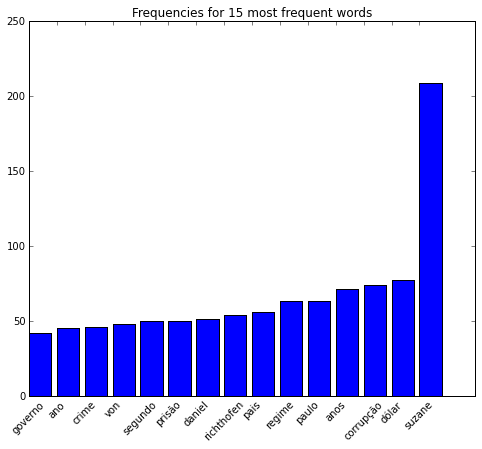

In [143]:
number_words=15      
w_items = freq_words.items()
w_items.sort(key = lambda wc: wc[1])
print 'Number of unique words:',len(w_items)
#print('{} least frequent words:').format(number_words)
#print_vk(w_items[:10])
#print('{} most frequent words:').format(number_words)
#print_vk(w_items[:-10:-1])
plot_word_histogram(w_items, number_words,'Frequencies for {} most frequent words'.format(number_words));

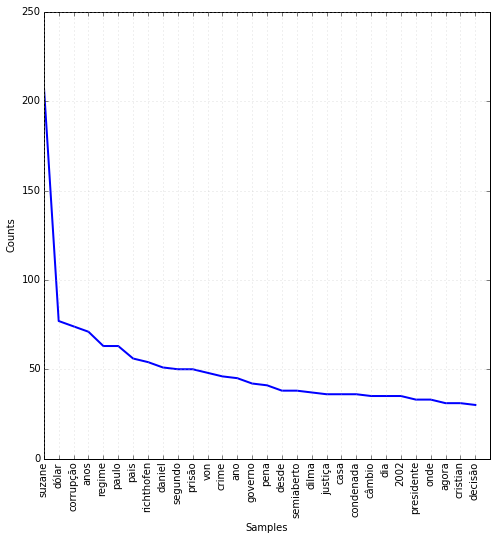

In [144]:
fd_words = nltk.FreqDist(freq_words)
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8,8)) 
fd_words.plot(30)

E a distribuição cumulativa das frequências:

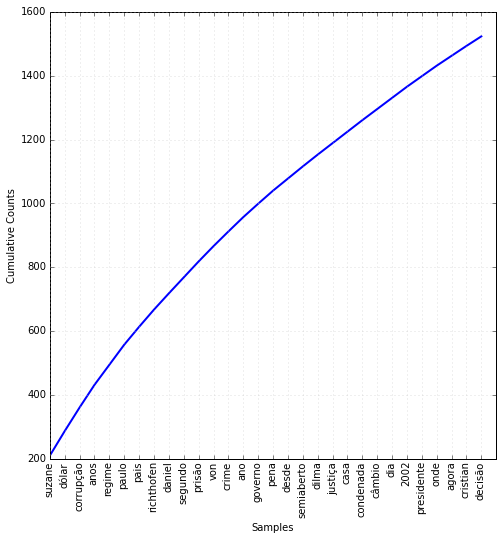

In [145]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8,8)) 
fd_words.plot(30, cumulative = True)

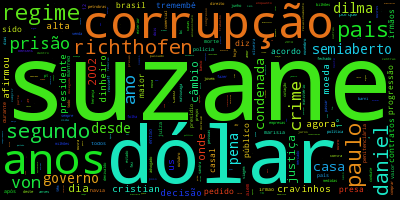

In [146]:
count = np.array(freq_words.values())
words = np.array(freq_words.keys())
count = count.astype(int)
make_wordcloud(words, count, 'test.png')
Image(filename='test.png', width=640, height=480)

Vamos agora construir um grafo de palavras para estudar co-ocorrências nos textos dos feeds

Abordagem e funções aproveitadas de https://github.com/ipython/talks/blob/master/notebook/text_utils.py

In [147]:
def all_pairs(items):
    """Make all unique pairs (order doesn't matter)"""
    pairs = []
    nitems = len(items)
    for i, wi in enumerate(items):
        for j in range(i+1, nitems):
            pairs.append((wi, items[j]))
    return pairs

def co_occurrences(lines, words):
    """Return histogram of co-occurrences of words in a list of lines.

    Parameters
    ----------
    lines : list
      A list of strings considered as 'sentences' to search for co-occurrences.

    words : list
      A list of words from which all unordered pairs will be constructed and
      searched for co-occurrences.
    """
    wpairs = all_pairs(words)

    # Now build histogram of co-occurrences
    co_occur = {}
    for w1, w2 in wpairs:
        rx = re.compile('%s .*%s|%s .*%s' % (w1, w2, w2, w1))
        co_occur[w1, w2] = sum([1 for line in lines if rx.search(line)])

    return co_occur

def co_occurrences_graph(word_hist, co_occur, cutoff=0):
    """Convert a word histogram with co-occurrences to a weighted graph.
    Edges are only added if the count is above cutoff.
    """
    g = nx.Graph()
    for word, count in word_hist:
        g.add_node(word, count=count)
    for (w1, w2), count in co_occur.iteritems():
        if count<=cutoff:
            continue
        g.add_edge(w1, w2, weight=count)
    return g

In [148]:
n_nodes = 10
popular = w_items[-n_nodes:]
pop_words = [wc[0] for wc in popular]
co_occur = co_occurrences(list_raw_texts, pop_words)
wgraph = co_occurrences_graph(popular, co_occur, cutoff=1)
wgraph = list(nx.connected_component_subgraphs(wgraph))[0]
centrality = nx.eigenvector_centrality_numpy(wgraph)
c = centrality.items()
c.sort(key=lambda x:x[1], reverse=True)
print '\nGraph centrality'
for node, cent in c:
    print "%15s: %.3g" % (node, float(cent))


Graph centrality
           anos: 0.574
         prisão: 0.539
           pais: 0.475
         regime: 0.387
          dólar: 0.039
      corrupção: 0.039


In [149]:
rad0 = 0.2
def rescale_arr(arr, amin, amax):
    """Rescale an array to a new range.
    Return a new array whose range of values is (amin, amax).
    Parameters
    ----------
    arr : array-like
    amin : float
      new minimum value
    amax : float
      new maximum value

    Examples
    --------
    >>> a = np.arange(5)
    >>> rescale_arr(a,3,6)
    array([ 3.  ,  3.75,  4.5 ,  5.25,  6.  ])
    """
    # old bounds
    m = arr.min()
    M = arr.max()
    # scale/offset
    s = float(amax-amin)/(M-m)
    d = amin - s*m

    # Apply clip before returning to cut off possible overflows outside the
    # intended range due to roundoff error, so that we can absolutely guarantee
    # that on output, there are no values > amax or < amin.
    return np.clip(s*arr+d,amin,amax)

def plot_graph(wgraph, pos=None, fig=None, title=None):
    """Conveniently summarize graph visually"""

    # config parameters
    edge_min_width= 3
    edge_max_width= 12
    label_font = 16
    node_font = 18
    node_alpha = 0.4
    edge_alpha = 0.55
    edge_cmap = plt.cm.Spectral

    # Create figure
    if fig is None:
        fig, ax = plt.subplots()
    else:
        ax = fig.add_subplot(111)
    fig.subplots_adjust(0,0,1)

    # Plot nodes with size according to count
    sizes = []
    degrees = []
    for n, d in wgraph.nodes_iter(data=True):
        sizes.append(d['count'])
        degrees.append(wgraph.degree(n))

    sizes = rescale_arr(np.array(sizes, dtype=float), 100, 1000)

    # Compute layout and label edges according to weight
    pos = nx.spring_layout(wgraph) if pos is None else pos
    labels = {}
    width = []
    for n1, n2, d in wgraph.edges_iter(data=True):
        w = d['weight']
        labels[n1, n2] = w
        width.append(w)

    width = rescale_arr(np.array(width, dtype=float), edge_min_width, 
                        edge_max_width)

    # Draw
    nx.draw_networkx_nodes(wgraph, pos, node_size=sizes, node_color=degrees,
                           alpha=node_alpha)
    nx.draw_networkx_edges(wgraph, pos, width=width, edge_color=width,
                           edge_cmap=edge_cmap, alpha=edge_alpha)
    nx.draw_networkx_edge_labels(wgraph, pos, edge_labels=labels, 
                                 font_size=label_font)
    nx.draw_networkx_labels(wgraph, pos, font_size=node_font, font_weight='bold')
    if title is not None:
        ax.set_title(title, fontsize=label_font)
    ax.set_xticks([])
    ax.set_yticks([])

    # Mark centrality axes
    kw = dict(color='k', linestyle='-')
    cross = [ax.axhline(0, **kw), ax.axvline(rad0, **kw)]
    [ l.set_zorder(0) for l in cross]
    
def centrality_layout(wgraph, centrality):
    """Compute a layout based on centrality.
    """
    # Create a list of centralities, sorted by centrality value
    cent = sorted(centrality.items(), key=lambda x:float(x[1]), reverse=True)
    nodes = [c[0] for c in cent]
    cent  = np.array([float(c[1]) for c in cent])
    rad = (cent - cent[0])/(cent[-1]-cent[0])
    rad = rescale_arr(rad, rad0, 1)
    angles = np.linspace(0, 2*np.pi, len(centrality))
    layout = {}
    for n, node in enumerate(nodes):
        r = rad[n]
        th = angles[n]
        layout[node] = r*np.cos(th), r*np.sin(th)
    return layout

Graph visualization for query:


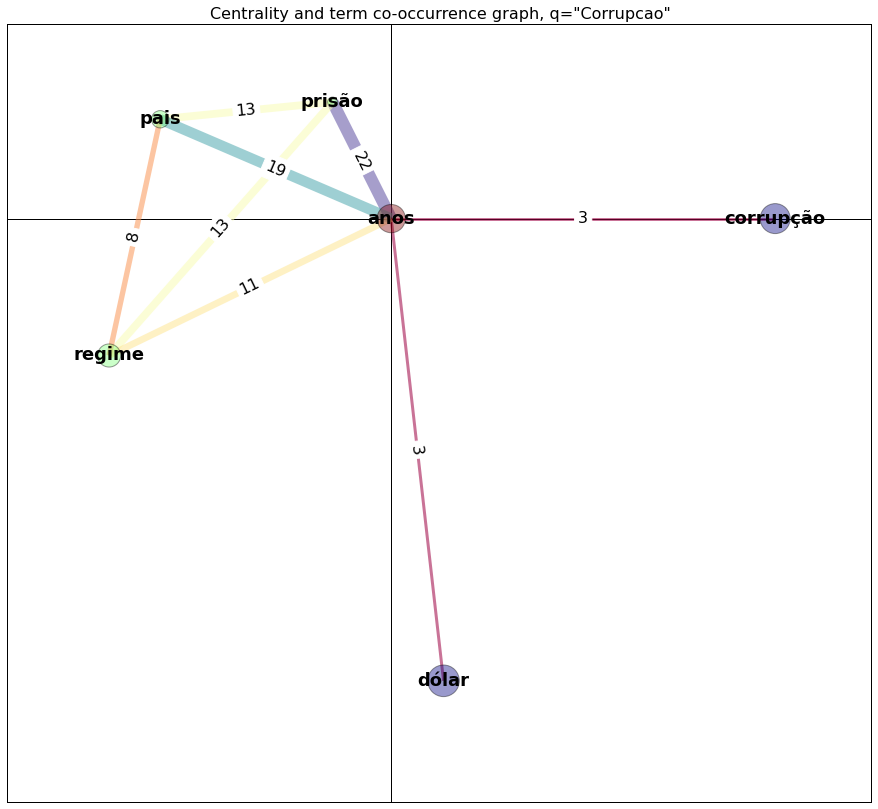

In [150]:
print "Graph visualization for query:"
plot_graph(wgraph, centrality_layout(wgraph, centrality), 
           plt.figure(figsize=(12,12)), 
           title = u'Centrality and term co-occurrence graph, q="{}"'.format(query))

Para entender os contextos, uma análise de concordâncias
(palavras associadas à expressão escolhida, posicionadas na mesma sentença):

In [151]:
tknzr = nltk.tokenize.WordPunctTokenizer()
tokens = tknzr.tokenize(raw_texts) # texto com stopwords
#tokens = tknzr.tokenize(cleaned_texts) # texto sem stopwords
nltk_text = nltk.Text(tokens)
nltk_text.concordance(query, width=128, lines=10)

No matches


Palavras que ocorrem em contextos similares (associadas às mesmas palavras que a consulta):

In [152]:
nltk_text.similar(query)

No matches


As colocações (que não são co-ocorrências) nos informam sobre as palavras (quaisquer, não necessariamente ligadas à consulta) que ocorrem conjuntamente (bigramas frequentes):
http://en.wikipedia.org/wiki/Collocation
http://en.wikipedia.org/wiki/Co-occurrence

In [153]:
nltk_text.collocations(num=100, window_size=2)

von richthofen; são paulo; dos pais; regime semiaberto; ministério
público; suzane von; acordo com; denivaldo barni; seis meses; dilma
rousseff; banco central; regime fechado; oliveira armani; morte dos;
pela morte; foram vendidos; zona sul; estados unidos; execuções
criminais; regina gomes; sandra regina; juíza sueli; lava jato; daniel
cravinhos; elize matsunaga; irmãos cravinhos; dólar comercial; foi
condenada; swap cambial; por exemplo; apresenta anotação; infração
disciplinar; lote total; sacos plásticos; toalha molhada; moeda norte;
desferiram golpes; fator desabonador; afirmou que; havia sido; herança
dos; foram condenados; nesta segunda; dinheiro vivo; deste ano;
presidente dilma; cíntia tucunduva; protagonizavam cenas; dois
cobriram; histórico prisional; nova york; com vencimento; rio claro;
andreas von; qualquer outro; ano passado; desde 2009; maior valor;
acabou usando; classe média; presas casadas; dólar turismo; que não;
após matarem; responsável pelo; polícia federal; oper

Collocations are expressions of multiple words which commonly co-occur.

Below we are using Pointwise Mutual Information.

http://en.wikipedia.org/wiki/Pointwise_mutual_information

In [154]:
max_items = 50
freq_min_b = 10
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder2 = nltk.collocations.BigramCollocationFinder.from_words(nltk_text)
finder2.apply_word_filter(lambda w: w in string.punctuation)
finder2.apply_freq_filter(freq_min_b)
for a, b in finder2.nbest(bigram_measures.pmi, max_items):
    print a, b

oliveira armani
denivaldo barni
banco central
seis meses
ministério público
dilma rousseff
foram vendidos
von richthofen
irmãos cravinhos
regime fechado
39 anos
regime semiaberto
", diz
pela morte
são paulo
12 anos
38 anos
daniel cravinhos
dólar comercial
por exemplo
morte dos
dos pais
", disse
os irmãos
acordo com
todos os
foi condenada
suzane von
na penitenciária
não há
no brasil
e seis
na casa
no dia
fora da
do casal
da polícia
em 1º
do crime
em 2002
do presídio
os pais
para 1º
o bc
manfred e
e marísia
afirmou que
do ano
o advogado
equivalente a


In [155]:
max_items = 50
freq_min_t = 6
trigram_measures = nltk.collocations.TrigramAssocMeasures()
finder3 = nltk.collocations.TrigramCollocationFinder.from_words(nltk_text)
finder3.apply_word_filter(lambda w: w in string.punctuation)
finder3.apply_ngram_filter(lambda w1, w2, w3:  w1 in ['da', 'de', 'das'])
finder3.apply_freq_filter(freq_min_t)
for a, b, c in finder3.nbest(trigram_measures.pmi, max_items):
    print a, b, c

sandra regina gomes
presidente dilma rousseff
palácio do planalto
andreas von richthofen
vencimento em 1º
herança dos pais
morte dos pais
marísia von richthofen
e seis meses
assassinato dos pais
zona sul de
pela morte dos
os irmãos cravinhos
manfred e marísia
dias fora da
suzane von richthofen
o ministério público
contratos de swap
dormiam em sua
fora da prisão
em regime fechado
1º de abril
equivalente a us
marísia e manfred
ano que vem
seis meses de
31 de outubro
a moeda norte
folha de s
para simular um
anos e seis
casas de câmbio
1º de dezembro
tribunal de justiça
condenada a 39
nas casas de
outubro de 2002
em sua casa
38 anos e
com vencimento em
durante o dia
e marísia von
em são paulo
a 39 anos
novembro de 2002
em regime semiaberto
o dólar comercial
penitenciária de tremembé
39 anos de
sul de são


In [156]:
for a, b in (finder2.above_score(bigram_measures.raw_freq,1.0 / len(list(nltk.bigrams(tokens))))):
        print a, b

a a
que a
de suzane
são paulo
com a
von richthofen
a corrupção
com o
que o
o dólar
dos pais
para o
de prisão
suzane von
para a
que não
regime semiaberto
de são
e a
do dólar
1º de
do crime
a presidente
acordo com
anos de
condenada a
de acordo
o que
a moeda
a progressão
de câmbio
o governo
e o
os irmãos
suzane e
em regime
de 2002
de tremembé
que os
a us
do ano
em 2002
em são
que ela
todos os
12 anos
afirmou que
daniel e
ministério público
morte dos
o bc
outubro de
é o
", diz
a justiça
combate a
de corrupção
do casal
e suzane
em que
manfred e
não se
os pais
progressão de
39 anos
da prisão
de regime
e marísia
no dia
pela morte
que suzane
regime fechado
de outubro
de r
denivaldo barni
dilma rousseff
e que
foi condenada
o advogado
o regime
segundo a
a 39
a delegada
casas de
com uma
daniel cravinhos
de oliveira
de pena
do governo
do que
em 1º
em sua
fora da
no brasil
não há
o valor
seis meses
38 anos
a jovem
a juíza
além de
anos e
banco central
cerca de
de novembro
depois de
durante o
dólar c

In [157]:
for a, b, c in finder3.above_score(trigram_measures.raw_freq,1.0 / len(list(nltk.trigrams(tokens)))):
        print a, b, c

suzane von richthofen
a a corrupção
em são paulo
anos de prisão
morte dos pais
combate a a
manfred e marísia
casas de câmbio
em 1º de
fora da prisão
39 anos de
a 39 anos
acordo com a
daniel e suzane
e seis meses
em regime fechado
o ministério público
o regime semiaberto
outubro de 2002
para 1º de
acordo com o
condenada a 39
equivalente a us
o dólar comercial
a progressão de
anos e seis
herança dos pais
o equivalente a
pela morte dos
presidente dilma rousseff
progressão de pena
tribunal de justiça
38 anos e
com vencimento em
contratos de swap
em regime semiaberto
em sua casa
foi condenada a
meses de prisão
os irmãos cravinhos
para o regime
seis meses de
vencimento em 1º
1º de abril
a presidente dilma
a venda de
alta do dólar
andreas von richthofen
ano que vem
do ano que
dormiam em sua
folha de s
marísia e manfred
penitenciária de tremembé
que a corrupção
sandra regina gomes
1º de dezembro
31 de outubro
a a venda
a alta do
a moeda norte
assassinato dos pais
comportamento de suzane
dias f

In [158]:
from nltk.util import ngrams
n = 4
xgrams = ngrams(tokens, n)
xgrams_counter = Counter(xgrams)
df_ngrams = pd.DataFrame(xgrams_counter.items(), columns = [u'n-gramas',u'Frequência'])
df_ngrams = df_ngrams.sort_index(by=u'Frequência', ascending=False)
df_ngrams.set_index([u'n-gramas'], inplace=True)
df_ngrams[0:40]

,Frequência
n-gramas,
"(r, $, 3, ,)",19
"(., de, acordo, com)",15
"(combate, a, a, corrupção)",14
"(suzane, von, richthofen, ,)",12
"(de, acordo, com, a)",11
"(39, anos, de, prisão)",10
"(equivalente, a, us, $)",10
"(de, s, ., paulo)",10
"(,, suzane, von, richthofen)",10


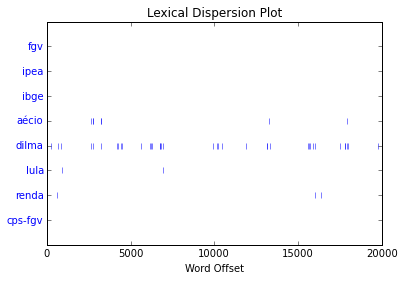

In [159]:
nltk_text.dispersion_plot([u'fgv', 
                      u'ipea', 
                      u'ibge',
                      u'aécio',
                      u'dilma',
                      u'lula',
                      u'renda',
                      u'cps-fgv',
                      ])

As funções a seguir permitem extrair as frases mais significativas do texto (sumarização automática)

In [164]:
def score_sentences(sentences, important_words):
    # Approach taken from "The Automatic Creation of Literature Abstracts" by H.P. Luhn
    CLUSTER_THRESHOLD = 5  # Distance between words to consider
    scores = []
    sentence_idx = -1
    #for s in [nltk.tokenize.word_tokenize(s) for s in sentences]:
    punktw2 = nltk.tokenize.WordPunctTokenizer() #trocando pelo punkt (melhor?)
    for s in [punktw2.tokenize(s) for s in sentences]:    
        sentence_idx += 1
        word_idx = []
        # For each word in the word list...
        for w in important_words:
            try:
                # Compute an index for where any important words occur in the sentence
                word_idx.append(s.index(w))
            except ValueError, e: # w not in this particular sentence
                pass
        word_idx.sort()
        # It is possible that some sentences may not contain any important words at all
        if len(word_idx)== 0: continue
        # Using the word index, compute clusters by using a max distance threshold
        # for any two consecutive words
        clusters = []
        cluster = [word_idx[0]]
        i = 1
        while i < len(word_idx):
            if word_idx[i] - word_idx[i - 1] < CLUSTER_THRESHOLD:
                cluster.append(word_idx[i])
            else:
                clusters.append(cluster[:])
                cluster = [word_idx[i]]
            i += 1
        clusters.append(cluster)
        # Score each cluster. The max score for any given cluster is the score 
        # for the sentence
        max_cluster_score = 0
        for c in clusters:
            significant_words_in_cluster = len(c)
            total_words_in_cluster = c[-1] - c[0] + 1
            score = 1.0 * significant_words_in_cluster \
                * significant_words_in_cluster / total_words_in_cluster
            if score > max_cluster_score:
                max_cluster_score = score
        scores.append((sentence_idx, score))
    return scores

In [165]:
def summarize(txt):
    TOP_SENTENCES = 10  # Number of sentences to choose on "top n"
    N = 100  # Number of words to consider
    #sentences = [s for s in nltk.tokenize.sent_tokenize(txt)]
    punkts = nltk.tokenize.PunktSentenceTokenizer() #trocando pelo punkt (melhor?)
    punktw = nltk.tokenize.WordPunctTokenizer() #trocando pelo punkt (melhor?)
    sentences = [s for s in punkts.tokenize(txt)]
    normalized_sentences = [s.lower() for s in sentences]
    words = [w.lower() for sentence in normalized_sentences for w in punktw.tokenize(sentence)]
    fdist = nltk.FreqDist(words)
    top_n_words = [w[0] for w in fdist.items() if w[0] not in ignore_words][:N]
    scored_sentences = score_sentences(normalized_sentences, top_n_words)
    # First approach:
    # Filter out non-significant sentences by using the average score plus a
    # fraction of the std dev as a filter
    avg = np.mean([s[1] for s in scored_sentences])
    std = np.std([s[1] for s in scored_sentences])
    mean_scored = [(sent_idx, score) for (sent_idx, score) in scored_sentences
                   if score > avg + 0.5 * std]
    # Second Approach: 
    # Return only the top N ranked sentences
    top_n_scored = sorted(scored_sentences, key=lambda s: s[1])[-TOP_SENTENCES:]
    top_n_scored = sorted(top_n_scored, key=lambda s: s[0])
    # Decorate the post object with summaries
    return dict(top_n_summary=[sentences[idx] for (idx, score) in top_n_scored],
                mean_scored_summary=[sentences[idx] for (idx, score) in mean_scored])

In [166]:
sumarios = summarize(raw_texts)
sumarios['top_n_summary'] = set(sumarios['top_n_summary'])
sumarios['mean_scored_summary'] = set(sumarios['mean_scored_summary'])

print(u'frases mais importantes(1):\n')
for s in sumarios['top_n_summary']:
    print(u'{}\n'.format(s))

frases mais importantes(1):

pessoas que conversaram com suzane recentemente afirmam que ela pretendia fazer uma cerimônia no começo de novembro para comemorar sua união.

suzane também pediu a a juíza que não fosse mais representada pelos advogados denivaldo barni e denivaldo barni junior.

a receita da companhia com venda de combustíveis sofre impacto da cotação no exterior porque suas refinarias precisam de grande volume de petróleo leve, comprado no exterior, para produzir gasolina e diesel, já que o óleo extraído no brasil, ainda predominantemente da bacia de campos, é pesado.

a justiça reconhece que suzane mantém bom relacionamento com as demais presidiárias.

suzane, que não conseguia se levantar e queixava-se de muita dor de cabeça após o choque, foi levada, com escolta da pm, até o hospital regional de taubaté, onde foi submetida a exames de tomografia de crânio, coluna cervical , tórax e abdômen.

os pais de suzane foram mortos na casa da família, com a ajuda do irmão de dan

In [167]:
print(u'\nfrases mais importantes(2):\n')
for s in sumarios['mean_scored_summary']:
    print(u'{}\n'.format(s))


frases mais importantes(2):

pessoas que conversaram com suzane recentemente afirmam que ela pretendia fazer uma cerimônia no começo de novembro para comemorar sua união.

suzane, que não conseguia se levantar e queixava-se de muita dor de cabeça após o choque, foi levada, com escolta da pm, até o hospital regional de taubaté, onde foi submetida a exames de tomografia de crânio, coluna cervical , tórax e abdômen.

a receita da companhia com venda de combustíveis sofre impacto da cotação no exterior porque suas refinarias precisam de grande volume de petróleo leve, comprado no exterior, para produzir gasolina e diesel, já que o óleo extraído no brasil, ainda predominantemente da bacia de campos, é pesado.



Extração de palavras relevantes usando TF-IDf  
http://radimrehurek.com/gensim/models/tfidfmodel.html  
http://radimrehurek.com/gensim/tutorial.html  
http://radimrehurek.com/gensim/tut2.html  

In [168]:
tokens_once = [key for key in freq_words.keys() if freq_words[key]==1]
texts = [[word.strip(string.punctuation) for word in document.lower().split() if word not in ignore_words]
         for document in list_raw_texts]
texts = [[word for word in text if word not in tokens_once and len(word) > 1] for text in texts]
dictionary = gensim.corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]
tfidf = gensim.models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [169]:
x = 1
for doc in corpus_tfidf:
    print(u'\nRelevant Words in Document {}:\n'.format(x))
    relev = 0
    top_w = ''
    x+=1
    for w_in_dic, tfidf_w in doc:
        if tfidf_w > relev:
            top_w = w_in_dic
            relev = tfidf_w
    if top_w != '' and relev > 0:
        print('{}\t{}'.format(dictionary[top_w], relev)) #Rever questão do UTF-8
    else:
        print('Nothing relevant')


Relevant Words in Document 1:



UnicodeEncodeError: 'ascii' codec can't encode characters in position 12-13: ordinal not in range(128)